In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 77.1 MB/s eta 0:00:00


# Required Imports

In [17]:
import zipfile
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
from torch import FloatStorage
from sklearn.preprocessing import normalize
import faiss
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
#Extracting data from Zipfile

zip_path = "dataset.zip"
extract_path = "dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully")


Dataset extracted successfully


In [7]:
#Dataset Check

dataset_root = "dataset/dataset"
for category in os.listdir(dataset_root):
    category_path = os.path.join(dataset_root, category)
    print(category, "->", len(os.listdir(category_path)), "images")

stapler -> 400 images
lamp -> 400 images
bicycle -> 400 images
table -> 400 images
kettle -> 400 images
chair -> 400 images
toaster -> 400 images
fan -> 400 images
sofa -> 400 images
mug -> 400 images
coffemaker -> 400 images
cabinet -> 400 images


# DataSet Loading and Preprocessing

In [8]:
transform= transforms.Compose(
    [
        transforms.Resize((224,224)),  # resizing all images to a fixed size expected by pre-trained resnet-50
        transforms.ToTensor(), #converting images from PIL to tensors
        #normalizing images using imagenet statistics to match the distribution during model pre-training
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std= [0.229, 0.224, 0.225]

        )
    ]
)

#loading images from folders and assigning labels to each category
dataset = datasets.ImageFolder(
    root="dataset/dataset",
    transform=transform
)

#loading images in batches
dataloader= DataLoader(
    dataset,
    batch_size= 32,
    shuffle=False,
    num_workers=2  #uses 2 CPU
)

print("Total Images: ", len(dataset))
print("Classes: ", dataset.classes)

Total Images:  4800
Classes:  ['bicycle', 'cabinet', 'chair', 'coffemaker', 'fan', 'kettle', 'lamp', 'mug', 'sofa', 'stapler', 'table', 'toaster']


# Pre-trained Model Loading

In [9]:
resnet = models.resnet50(pretrained=True)

resnet.fc = nn.Identity() # Removing the classification layer and using Resnet-50 as a feature extractor

resnet.eval()  #setting model to evaluation mode to ensure stable behaviour of layers like BatchNorm during inference

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
#selecting gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Generating embeddings for the images

In [11]:
all_embeddings=[]
all_labels=[]

with torch.no_grad():  # disabling gradient tracking to make sure that only inference is happening
  for images, labels in dataloader:
    images= images.to(device)
    embeddings=resnet(images)  # passing images through resent to get the embeddings (op is 2048 numbers per image)
    embeddings=embeddings.cpu().numpy() # moving embeddings back to cpu
    all_embeddings.append(embeddings)
    all_labels.append(labels.numpy())

In [12]:
#combining batch-wise embeddings and labels into arrays for similarity search and evaluation
all_embeddings= np.vstack(all_embeddings)
all_labels= np.concatenate(all_labels)
print(all_embeddings.shape)
print(all_labels.shape)

(4800, 2048)
(4800,)


In [13]:
#Normalizing the embeddings using l2 normalization for fair similarity comparison
normalized_embeddings= normalize(all_embeddings, norm="l2")
print(normalized_embeddings.shape)

(4800, 2048)


# Creating FAISS Similarity index

In [14]:
embedding_dim= normalized_embeddings.shape[1]

index= faiss.IndexFlatIP(embedding_dim) # storing vectors as-is and comparing them using cosine similarity

index.add(normalized_embeddings.astype(np.float32)) #adding embeddings to index and converting them into 32-bit as Faiss only works with 32-bit

print("Total vectors in index: ", index.ntotal)

Total vectors in index:  4800


# Evaluating the system

In [48]:
#Loading the query image
query_img_path = "img4.jpg"

query_img = Image.open(query_img_path).convert("RGB") #converting into RGB to ensure image has exactly 3 channels


In [49]:
#pre-processing query image
query_tensor = transform(query_img) #same preprocessing as done on the dataset

query_tensor = query_tensor.unsqueeze(0) #adding batch dimension at position 0

query_tensor = query_tensor.to(device) # to ensure that model and input are on the same device

In [50]:
#generating the mebedding of the query image
with torch.no_grad():
    query_embedding = resnet(query_tensor)


In [51]:
#normalizing the embedding
query_embedding = query_embedding.cpu().numpy()
query_embedding = normalize(query_embedding, norm="l2")


In [52]:
#finding the top-10 most similar images to the query image

k = 10
scores, indices = index.search(
    query_embedding.astype(np.float32),
    k
)

print("Retrieved indices:", indices[0])
print("Similarity scores:", scores[0])


Retrieved indices: [4184  449  416  538  655  562  733  685  572  537]
Similarity scores: [0.8493943  0.84549177 0.8454572  0.8416963  0.83278227 0.8302327
 0.8159915  0.80649817 0.80614847 0.80253506]


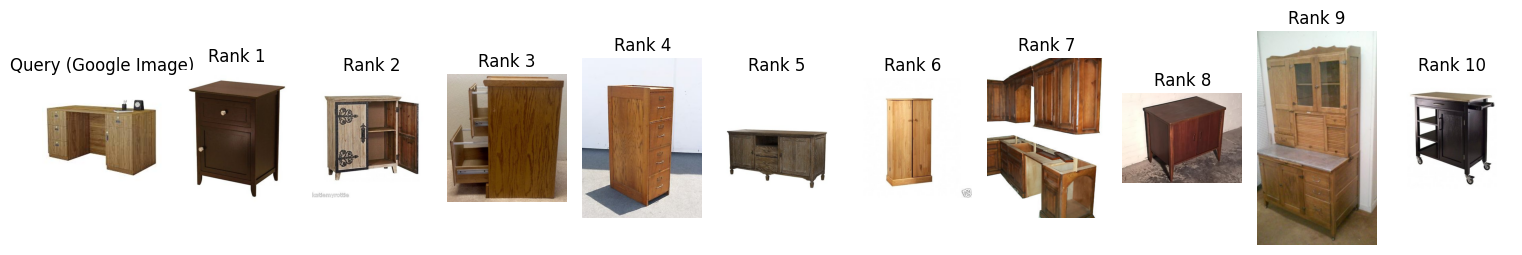

In [53]:
#Displaying the retrieved results
plt.figure(figsize=(15, 4))

# Query image
plt.subplot(1, k + 1, 1)
plt.imshow(query_img)
plt.title("Query (Google Image)")
plt.axis("off")

# Retrieved images
for i, idx in enumerate(indices[0]):
    img_path = dataset.samples[idx][0]
    img = Image.open(img_path)

    plt.subplot(1, k + 1, i + 2)
    plt.imshow(img)
    plt.title(f"Rank {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
